# Step 1. preprocessing according to [Zhang et al. 2020](https://www.biorxiv.org/content/10.1101/2020.06.04.105700v1)
- inputs: summary tables generated by Vizgen (George)
- output: `preprocessed_merfish_ad_mouse.hdf5`  `palette_dadmouse.json`

In [1]:
import sys
sys.path.insert(0, '/cndd2/fangming/projects/SingleCellRoutines')
import tqdm
import time
import pandas as pd
import numpy as np
from scipy import stats

from __init__scr import *
from __init__plots import *
import utils
import powerplot

# Read in data 

In [2]:
# raw counts
DATA_DIR = '../data/summary_tables_admouse'
data_dir = DATA_DIR
output_dir = DATA_DIR 

samples = [
    'Xulab_2_5_region_0', 
    'Xulab_2_5_region_1', 
    'Xulab_2_6_region_0',
    'Xulab_2_6_region_1',
    'Vizgen_region_0',
]
    

In [3]:
# palette
colors = [
    mpl.cm.get_cmap('tab20c').colors[0],
    mpl.cm.get_cmap('tab20c').colors[1],
    
    mpl.cm.get_cmap('tab20c').colors[4],
    mpl.cm.get_cmap('tab20c').colors[5],
    
    mpl.cm.get_cmap('tab20c').colors[8],
] 
palette = {}
for i, sample in enumerate(samples):
    palette[sample] = colors[i] 

In [4]:
ti = time.time()
allcounts = {}
metas = {}
i = 0

for sample in samples:
    print(sample)
    fdata = os.path.join(data_dir, '{}_cell_by_gene.csv'.format(sample))
    fmeta = os.path.join(data_dir, '{}_cell_metadata.csv'.format(sample))

    # metadata
    meta = pd.read_csv(fmeta, index_col=0)
    
    # gmat
    data = pd.read_csv(fdata, index_col=0)
    data = data.drop(data.filter(regex='^Blank-').columns, axis=1)
    cell_cov = data.sum(axis=1)
    meta['cell_cov'] = cell_cov
    
    # cell_cov
    if i == 0:
        genes = data.columns.values
    else:
        assert np.all(genes == data.columns)
        
    # record
    i += 1
    metas[sample] = meta
    allcounts[sample] = data
    print(time.time()-ti)
    
#     break

Xulab_2_5_region_0
2.0857772827148438
Xulab_2_5_region_1
3.9015982151031494
Xulab_2_6_region_0
5.99544358253479
Xulab_2_6_region_1
8.125258207321167
Vizgen_region_0
12.03354001045227


# Processing (planned)

## group1
- remove cells with volume < 100um^3 or > 3*median volume (~1000um^3) 
- normalize counts by imaged volume of each cell 
- normalize mean total RNA counts per cell to a same mean value (250) for each experiment
- remove cells with counts <2% or >98%
- (not done) remove doublets using scrublet

## group2
- normalize the counts for each cell by median of all cells
- log transform

## group3
- z-score for each gene
- PCA for the first 35 PCs
- Louvain using scanpy (bootstrap and optimal k)
- 2 round clustering (redo PCAs and clusterings ...)

# Diagnosis

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


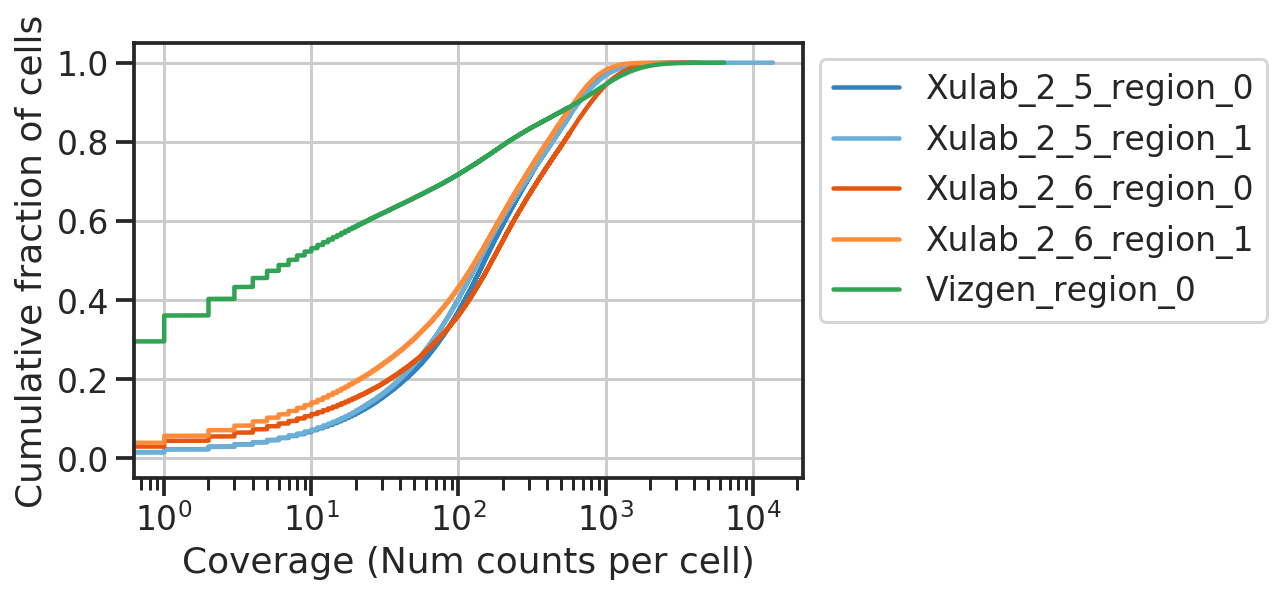

In [5]:
fig, ax = plt.subplots()
for sample in metas.keys():
    color = palette[sample]
    cell_cov = metas[sample]['cell_cov']
    med = cell_cov.median()
    powerplot.gen_cdf(cell_cov, ax=ax, label=sample, color=color)
    
#     sns.distplot(cell_cov, ax=ax, label=sample_name, color=color, )
#     ax.axvline(med, color=color, linestyle='--')
    
ax.legend(bbox_to_anchor=(1,1))
ax.set_xscale('log')
ax.set_xlabel('Coverage (Num counts per cell)')
ax.set_ylabel('Cumulative fraction of cells')
plt.show()

median: 567.5949388057556
median: 623.8762494855238
median: 563.0041631275942
median: 531.4956150929905
median: 65.15773178026032


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


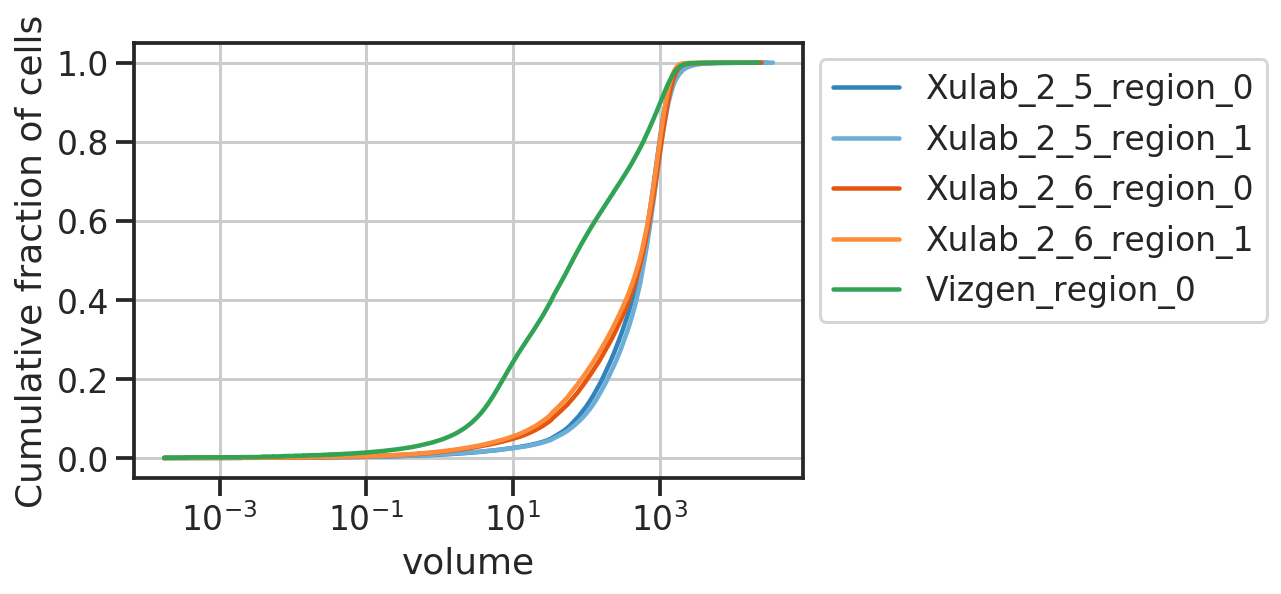

In [6]:
fig, ax = plt.subplots()
for sample in metas.keys():
    color = palette[sample]
    x = 'volume'
    _x = metas[sample][x]
    med = _x.median()
    powerplot.gen_cdf(_x, ax=ax, label=sample, color=color)
    print("median: {}".format(med))
    
#     sns.distplot(cell_cov, ax=ax, label=sample_name, color=color, )
#     ax.axvline(med, color=color, linestyle='--')
    
ax.legend(bbox_to_anchor=(1,1))
ax.set_xscale('log')
ax.set_xlabel(x)
ax.set_ylabel('Cumulative fraction of cells')
plt.show()

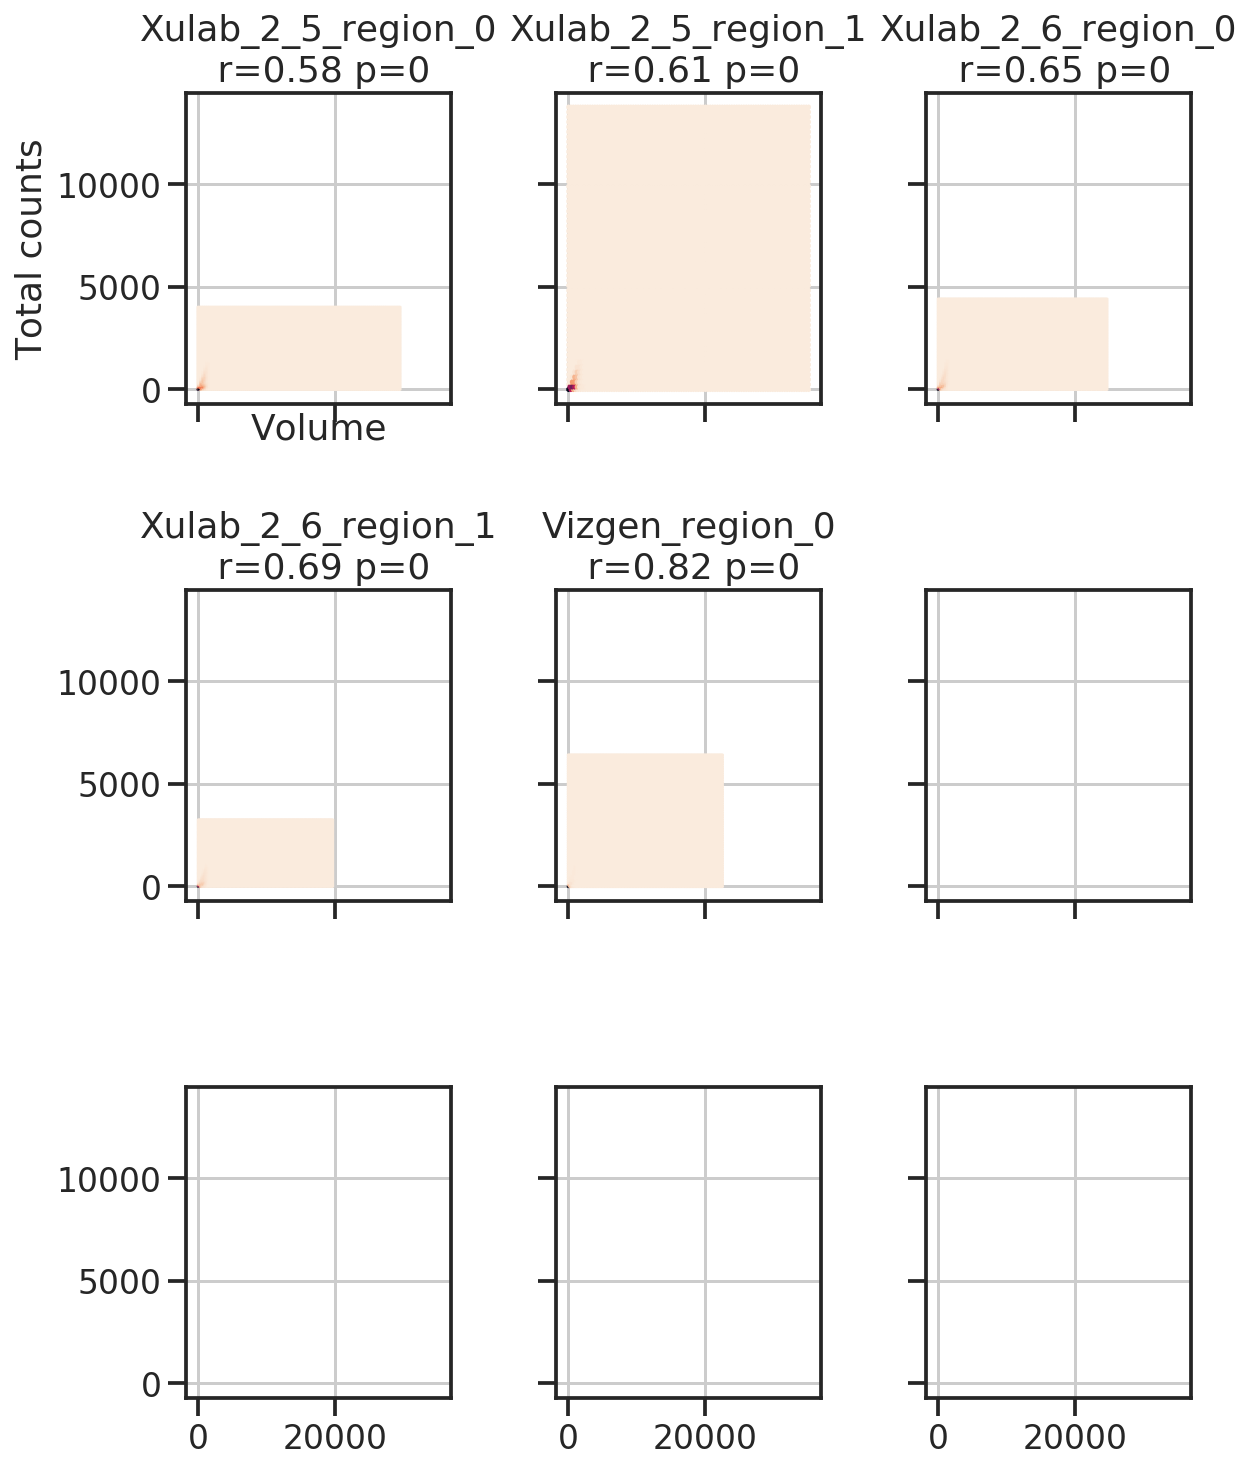

In [7]:
fig, axs = plt.subplots(3,3,figsize=(3*3,3*4), sharex=True, sharey=True)
for i, (sample, ax) in enumerate(zip(metas.keys(), axs.flat)):
    meta = metas[sample]
    color = palette[sample]
    x, y, data = 'volume', 'cell_cov', meta
    ax.hexbin(data[x].values, data[y].values, cmap='rocket_r')
    
    r, p = stats.pearsonr(data[x].values, data[y].values)
    ax.set_title("{}\n r={:.2g} p={:.2g}".format(sample, r, p))
    if i == 0:
        ax.set_xlabel('Volume')
        ax.set_ylabel('Total counts')
    
fig.subplots_adjust(wspace=0.4, hspace=0.6) 
plt.show()

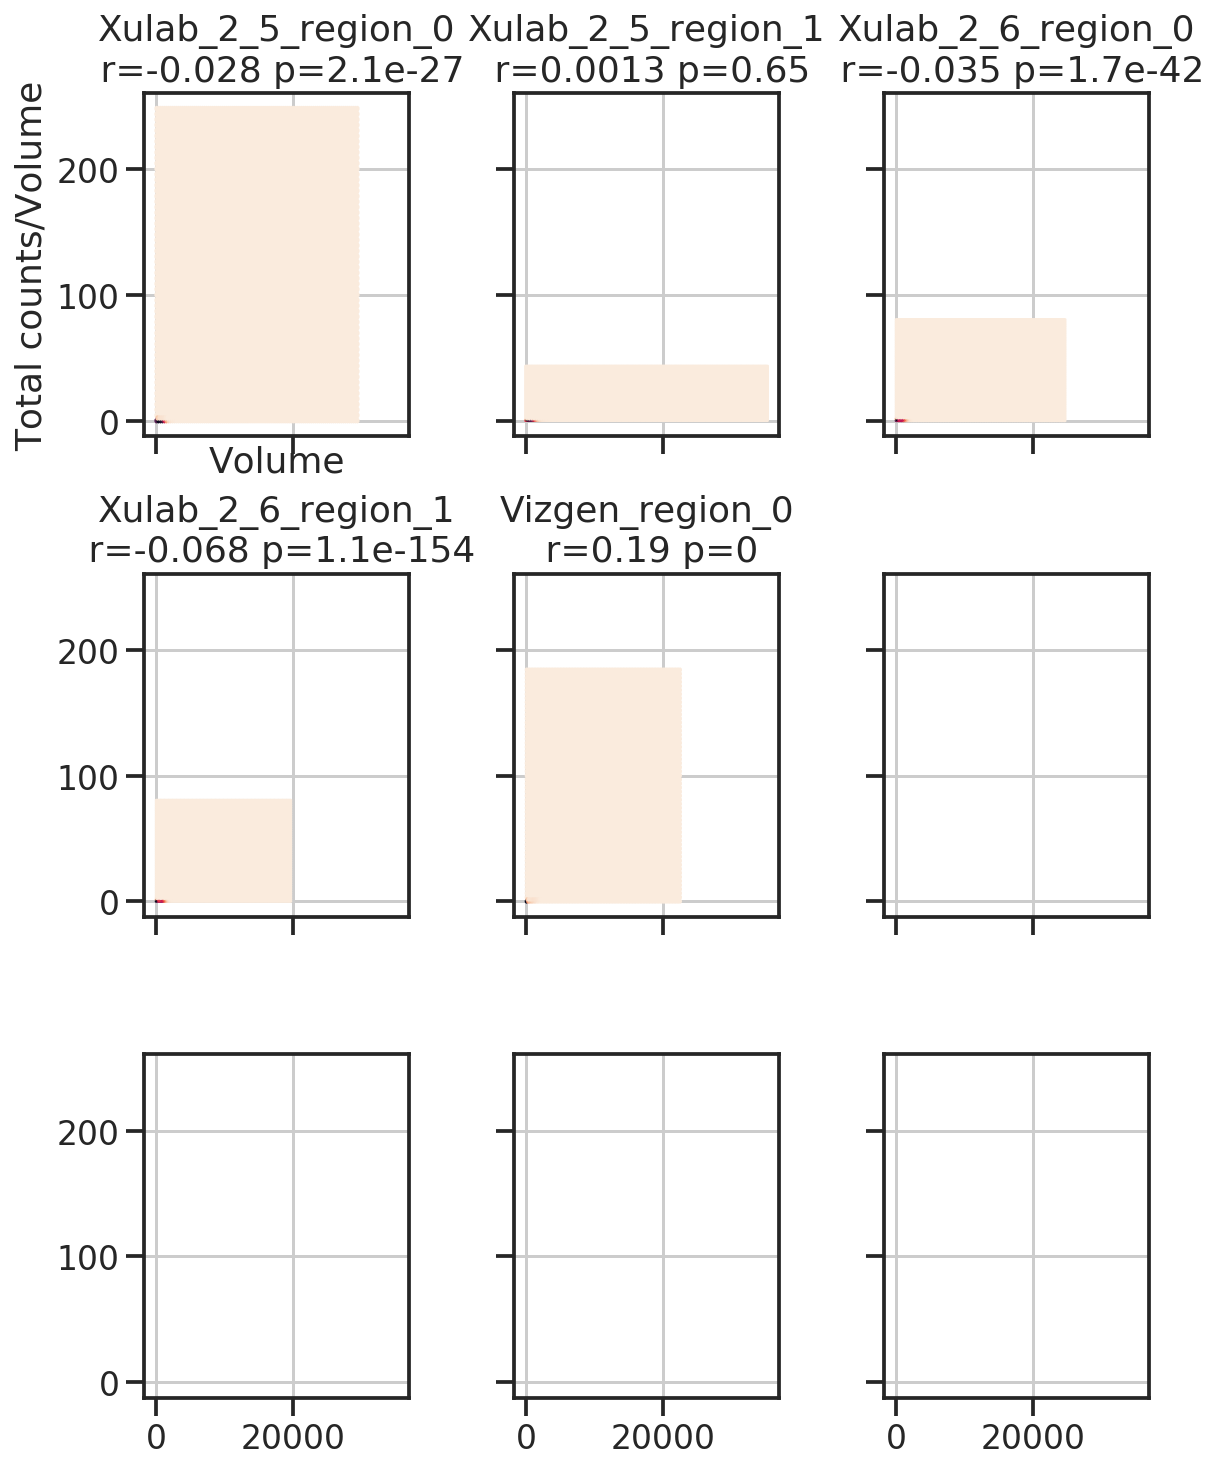

In [8]:
fig, axs = plt.subplots(3,3,figsize=(3*3,3*4), sharex=True, sharey=True)
for i, (sample, ax) in enumerate(zip(metas.keys(), axs.flat)):
    meta = metas[sample]
    color = palette[sample]
    x, y, data = 'volume', 'cell_cov', meta
    ax.hexbin(data[x].values, data[y].values/data[x].values, cmap='rocket_r')
    
    r, p = stats.pearsonr(data[x].values, data[y].values/data[x].values)
    ax.set_title("{}\n r={:.2g} p={:.2g}".format(sample, r, p))
    if i == 0:
        ax.set_xlabel('Volume')
        ax.set_ylabel('Total counts/Volume')
    
fig.subplots_adjust(wspace=0.4, hspace=0.4) 
plt.show()

## Implement processing 

## group1
- remove cells with volume < 100um^3 or > 3*median volume (~1000um^3) 
- normalize counts by imaged volume of each cell 
- remove cells with counts <2% or >98%

## group2
- normalize the counts for each cell by median of all cells
- log transform

In [9]:

import h5py
output = os.path.join(output_dir, 'processed_merfish_ad_mouse.hdf5')

if os.path.isfile(output):
    os.remove(output)

for sample in metas.keys():
    meta = metas[sample]
    counts = allcounts[sample]
    
    meta_p = meta.copy() #.head(1000)
    counts_p = counts.copy() #.head(1000)
    print(meta_p.shape, counts_p.shape)
    
    # step1 - filter cells based on volumes
    med_vol = meta_p['volume'].median()
    cond1 = (meta_p['volume'] < 100)
    cond2 = (meta_p['volume'] > 3*med_vol)
    print("remove {} cells".format(cond1.sum()))
    print("remove {} cells".format(cond2.sum()))
    meta_p = meta_p[~(cond1 | cond2)]
    counts_p = counts_p.loc[meta_p.index]
    print(meta_p.shape, counts_p.shape)
    
    # step2 - norm counts by volume
    med_vol = meta_p['volume'].median()
    norm_factor = meta_p['volume']/med_vol
    meta_p['cell_cov_norm'] = meta_p['cell_cov']/norm_factor
    counts_p = counts_p.divide(norm_factor, axis=0)
    
    # step3 - remove outliers
    p2 = np.percentile(meta_p['cell_cov_norm'], 2)
    p98 = np.percentile(meta_p['cell_cov_norm'], 98)
    cond3 = (meta_p['cell_cov_norm'] < p2)
    cond4 = (meta_p['cell_cov_norm'] > p98)
    print("remove {} cells".format(cond3.sum()))
    print("remove {} cells".format(cond4.sum()))
    meta_p = meta_p[~(cond3 | cond4)]
    counts_p = counts_p.loc[meta_p.index]
    print(meta_p.shape, counts_p.shape)
    
    # step4 - norm by the median
    med_cov = meta_p['cell_cov_norm'].median()
    norm_factor = meta_p['cell_cov_norm']/med_cov
    counts_p = counts_p.divide(norm_factor, axis=0)
    print("median norm cov {}".format(med_cov))
    
    # step5 - log
    counts_p = np.log10(counts_p+1)
    print(meta_p.shape, counts_p.shape)
    
    # save as hdf5
    meta_p.to_hdf(output, key='meta_'+sample, mode='a')
    counts_p.to_hdf(output, key='mat_'+sample, mode='a')
    
#     break

(147021, 9) (147021, 150)
remove 19165 cells
remove 3033 cells
(124823, 9) (124823, 150)
remove 2497 cells
remove 2497 cells
(119829, 10) (119829, 150)
median norm cov 231.84956154644868
(119829, 10) (119829, 150)
(130168, 9) (130168, 150)
remove 14628 cells
remove 3698 cells
(111842, 9) (111842, 150)
remove 2237 cells
remove 2237 cells
(107368, 10) (107368, 150)
median norm cov 200.17842693677727
(107368, 10) (107368, 150)
(148659, 9) (148659, 150)
remove 29093 cells
remove 3601 cells
(115965, 9) (115965, 150)
remove 2320 cells
remove 2320 cells
(111325, 10) (111325, 150)
median norm cov 291.99419847285463
(111325, 10) (111325, 150)
(152149, 9) (152149, 150)
remove 32970 cells
remove 3054 cells
(116125, 9) (116125, 150)
remove 2323 cells
remove 2323 cells
(111479, 10) (111479, 150)
median norm cov 233.42997081112117
(111479, 10) (111479, 150)
(288859, 9) (288859, 150)
remove 162435 cells
remove 101473 cells
(24951, 9) (24951, 150)
remove 0 cells
remove 499 cells
(24452, 10) (24452, 15

In [10]:
with h5py.File(output, 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['mat_Vizgen_region_0', 'mat_Xulab_2_5_region_0', 'mat_Xulab_2_5_region_1', 'mat_Xulab_2_6_region_0', 'mat_Xulab_2_6_region_1', 'meta_Vizgen_region_0', 'meta_Xulab_2_5_region_0', 'meta_Xulab_2_5_region_1', 'meta_Xulab_2_6_region_0', 'meta_Xulab_2_6_region_1']>


In [11]:
df = pd.read_hdf(output, 'mat_Xulab_2_5_region_0')
print(df.shape)
df.head()

(119829, 150)


,Syn1,Syp,Gphn,Dlg4,Tnf,Pdgfa,Igf1,Ngf,Ntf3,Bdnf,...,Slc6a3,Pitx3,Slc6a4,Fev,Hdc,Slc6a2,Pnmt,Pomc,Pdyn,Penk
1180572846630481441529138875642910508,0.000000,0.981684,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.586851,0.0,0.0
123728997372594040247704579971571050130,0.823139,1.090249,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
141838298513381706222849139789989533595,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
159299836930912089601219931918867429346,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
178901354552570069198396499727421283408,0.000000,0.000000,0.0,0.0,0.0,1.427503,0.0,1.427503,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [12]:
# set output as read only
!echo $output
!chmod 444 $output

../data/summary_tables_admouse/processed_merfish_ad_mouse.hdf5


In [19]:
# save palette as json
import json

file = '../data/summary_tables_admouse/palette_admouse.json'
with open(file, 'w') as f:
    json.dump(palette, f)
    
with open(file, 'r') as f:
    palette = json.load(f)
palette

{'Xulab_2_5_region_0': [0.19215686274509805,
  0.5098039215686274,
  0.7411764705882353],
 'Xulab_2_5_region_1': [0.4196078431372549,
  0.6823529411764706,
  0.8392156862745098],
 'Xulab_2_6_region_0': [0.9019607843137255,
  0.3333333333333333,
  0.050980392156862744],
 'Xulab_2_6_region_1': [0.9921568627450981,
  0.5529411764705883,
  0.23529411764705882],
 'Vizgen_region_0': [0.19215686274509805,
  0.6392156862745098,
  0.32941176470588235]}

# post-removal check

In [14]:
# output = '../data/processed_merfish_ad_mouse_rotated_june2_2021.hdf5'
samples = samples[:4]
metas = {sample: pd.read_hdf(output, 'meta_'+sample) for sample in samples}

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


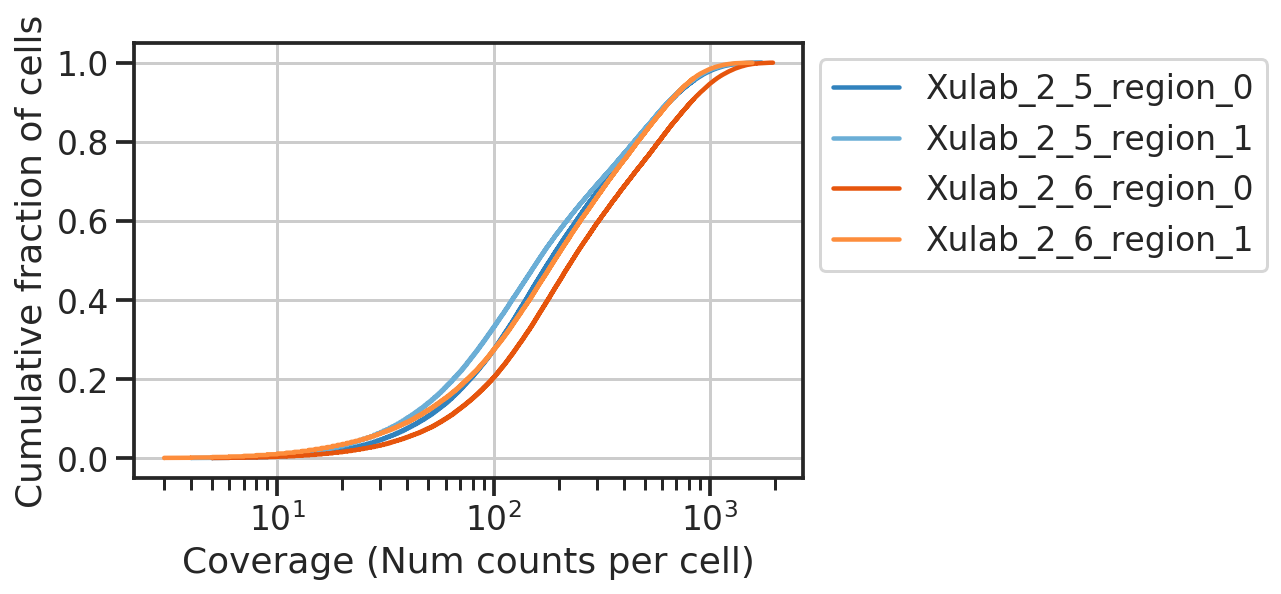

In [15]:
fig, ax = plt.subplots()
for sample in metas.keys():
    color = palette[sample]
    cell_cov = metas[sample]['cell_cov']
    med = cell_cov.median()
    powerplot.gen_cdf(cell_cov, ax=ax, label=sample, color=color)
    
#     sns.distplot(cell_cov, ax=ax, label=sample_name, color=color, )
#     ax.axvline(med, color=color, linestyle='--')
    
ax.legend(bbox_to_anchor=(1,1))
ax.set_xscale('log')
ax.set_xlabel('Coverage (Num counts per cell)')
ax.set_ylabel('Cumulative fraction of cells')
plt.show()

median: 648.3676764360926
median: 685.9669323066707
median: 714.4220782628703
median: 704.9667144923437


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


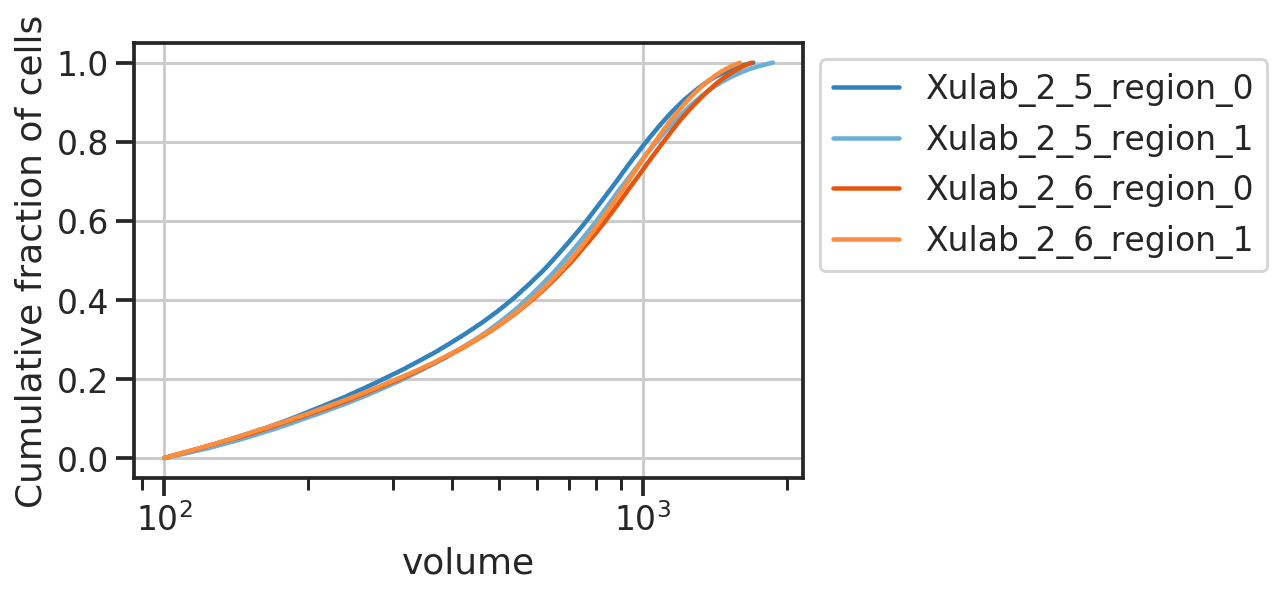

In [16]:
fig, ax = plt.subplots()
for sample in metas.keys():
    color = palette[sample]
    x = 'volume'
    _x = metas[sample][x]
    med = _x.median()
    powerplot.gen_cdf(_x, ax=ax, label=sample, color=color)
    print("median: {}".format(med))
    
#     sns.distplot(cell_cov, ax=ax, label=sample_name, color=color, )
#     ax.axvline(med, color=color, linestyle='--')
    
ax.legend(bbox_to_anchor=(1,1))
ax.set_xscale('log')
ax.set_xlabel(x)
ax.set_ylabel('Cumulative fraction of cells')
plt.show()

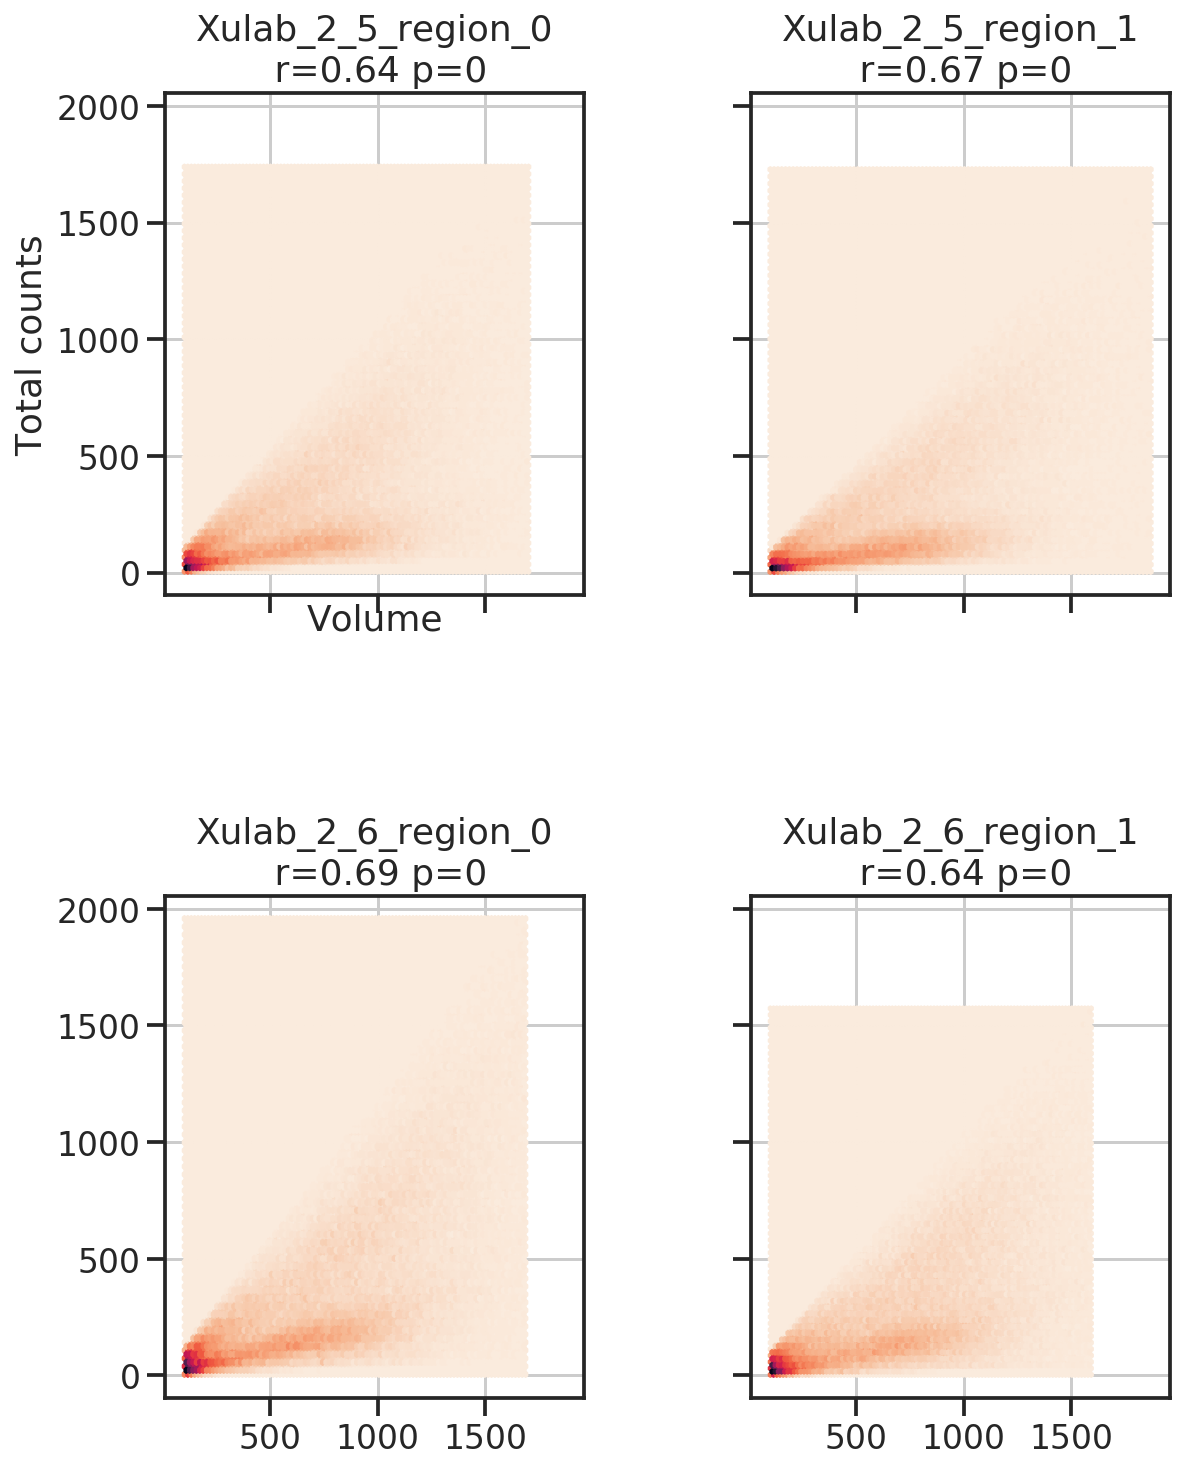

In [17]:
fig, axs = plt.subplots(2,2,figsize=(3*3,3*4), sharex=True, sharey=True)
for i, (sample, ax) in enumerate(zip(metas.keys(), axs.flat)):
    meta = metas[sample]
    color = palette[sample]
    x, y, data = 'volume', 'cell_cov', meta
    ax.hexbin(data[x].values, data[y].values, cmap='rocket_r')
    
    r, p = stats.pearsonr(data[x].values, data[y].values)
    ax.set_title("{}\n r={:.2g} p={:.2g}".format(sample, r, p))
    if i == 0:
        ax.set_xlabel('Volume')
        ax.set_ylabel('Total counts')
    
fig.subplots_adjust(wspace=0.4, hspace=0.6) 
plt.show()

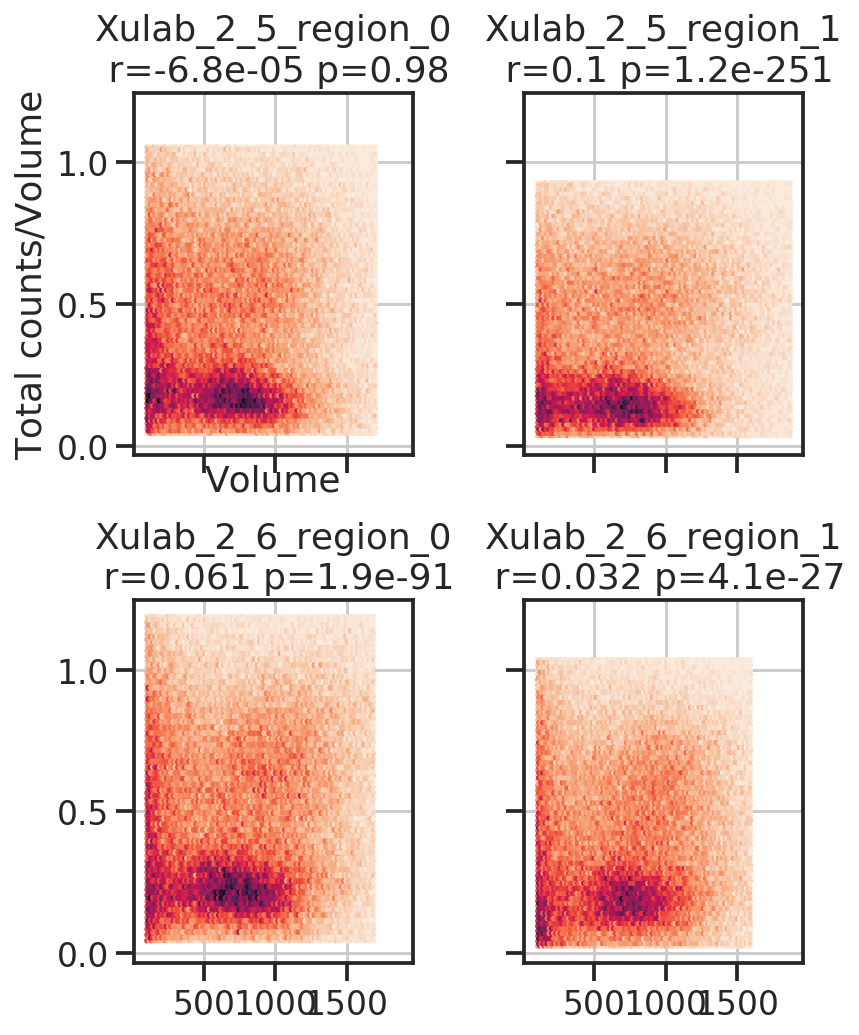

In [18]:
fig, axs = plt.subplots(2,2,figsize=(2*3,2*4), sharex=True, sharey=True)
for i, (sample, ax) in enumerate(zip(metas.keys(), axs.flat)):
    meta = metas[sample]
    color = palette[sample]
    x, y, data = 'volume', 'cell_cov', meta
    ax.hexbin(data[x].values, data[y].values/data[x].values, cmap='rocket_r')
    
    r, p = stats.pearsonr(data[x].values, data[y].values/data[x].values)
    ax.set_title("{}\n r={:.2g} p={:.2g}".format(sample, r, p))
    if i == 0:
        ax.set_xlabel('Volume')
        ax.set_ylabel('Total counts/Volume')
    
fig.subplots_adjust(wspace=0.4, hspace=0.4) 
plt.show()